<a href="https://colab.research.google.com/github/Dany-Santi-TSAN/computer-vision/blob/main/cv_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Import
# Basic
import os
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from keras.utils import to_categorical
from keras.applications.vgg16 import preprocess_input

# Progress tracking and image manipulation
from tqdm import tqdm # tqdm is used to display progress bars for long-running tasks
from PIL import Image  # PIL (Python Imaging Library)

# CNN
from keras import Sequential, Input, layers, optimizers, models
from keras.callbacks import EarlyStopping

# transfer learning
from keras.applications.vgg16 import VGG16

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Load and exploring data

In [ ]:
# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/drive/MyDrive/Colab Notebooks/transfer_learning')

In [ ]:
option_1 = True # Choose here

if option_1:
    !wget https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
    !unzip -q -n flowers-dataset.zip
else:
    from google.colab import drive
    drive.mount('/content/drive/')

--2025-04-24 07:53:41--  https://wagon-public-datasets.s3.amazonaws.com/flowers-dataset.zip
Resolving wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)... 3.5.67.130, 3.5.67.238, 52.92.0.25, ...
Connecting to wagon-public-datasets.s3.amazonaws.com (wagon-public-datasets.s3.amazonaws.com)|3.5.67.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104983809 (100M) [application/zip]
Saving to: ‘flowers-dataset.zip.1’

flowers-dataset.zip 100%[===================>] 100.12M  24.5MB/s    in 4.7s    

2025-04-24 07:53:46 (21.4 MB/s) - ‘flowers-dataset.zip.1’ saved [104983809/104983809]



In [ ]:
# store the path to the dataset in a variable
data_path = 'flowers'

# List the folders in the data directory, which correspond to the labels
labels = os.listdir(data_path)

# Display the labels
print("Labels trouvés dans le dataset :")
for label in labels:
    print(label)

Labels trouvés dans le dataset :
daisy
rose
dandelion


In [ ]:
def load_flowers_data(loading_method):
    # Determine the data path based on the loading method
    if loading_method == 'colab':
        data_path = '/content/drive/My Drive/Deep_learning_data/flowers'
    elif loading_method == 'direct':
        data_path = 'flowers/'

    # Define a dictionary to map class names to integer labels
    classes = {'daisy': 0, 'dandelion': 1, 'rose': 2}

    # Initialize lists to store images and their corresponding labels
    imgs = []
    labels = []

    # Iterate over each class and its corresponding label
    for (cl, i) in classes.items():
        # List all image files in the directory for the current class
        images_path = [elt for elt in os.listdir(os.path.join(data_path, cl)) if elt.find('.jpg') > 0]

        # Process each image file
        for img in tqdm(images_path[:300]):  # Limit to the first 300 images for each class
            path = os.path.join(data_path, cl, img)
            if os.path.exists(path):
                # Open the image file
                image = Image.open(path)

                # Resize the image to 256x256 pixels
                image = image.resize((256, 256))

                # Convert the image to a numpy array and append to the list of images
                imgs.append(np.array(image))

                # Append the corresponding label to the list of labels
                labels.append(i)

    # Convert the list of images to a numpy array
    X = np.array(imgs)

    # Determine the number of unique classes
    num_classes = len(set(labels))

    # Convert the list of labels to a one-hot encoded numpy array
    y = to_categorical(labels, num_classes)

    # Shuffle the dataset to ensure randomness
    p = np.random.permutation(len(X))
    X, y = X[p], y[p]

    # Split the dataset into training, validation, and test sets
    first_split = int(len(imgs) / 6.)
    second_split = first_split + int(len(imgs) * 0.2)
    X_test, X_val, X_train = X[:first_split], X[first_split:second_split], X[second_split:]
    y_test, y_val, y_train = y[:first_split], y[first_split:second_split], y[second_split:]

    # Return the training, validation, and test sets along with the number of classes
    return X_train, y_train, X_val, y_val, X_test, y_test, num_classes

In [ ]:
# Load flower dataset
X_train, y_train, X_val, y_val, X_test, y_test, num_classes = load_flowers_data('direct')

100%|██████████| 299/299 [00:03<00:00, 85.61it/s] 


In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)

(571, 256, 256, 3) (179, 256, 256, 3) (149, 256, 256, 3)


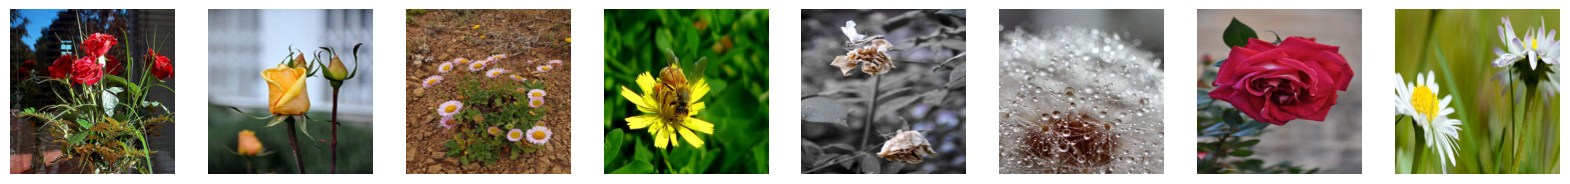

In [30]:
plt.figure(figsize=(20,15))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(X_train[i])
    # Remove the axes for a cleaner look
    plt.axis('off')

## Initialise baseline CNN

In [36]:
def initialize_model():
    model = Sequential()

    model.add(Input((256, 256, 3))) # input layer

    model.add(layers.Rescaling(1./255))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu')) # first layer
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=8, activation="relu")) # second layer
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(64, kernel_size=6, activation="relu")) # third layer
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Flatten()) # flatten

    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax')) # output

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [37]:
baseline_model = initialize_model()
baseline_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 247, 247, 16)   │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 82, 82, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 75, 75, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 20, 20, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       230,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 342,211 (1.31 MB)

 Trainable params: 342,211 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

history = baseline_model.fit(X_train, y_train,
                             validation_data=(X_val, y_val),
                             batch_size=32,
                             epochs=100,
                             callbacks=[es])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 7s/step - accuracy: 0.3180 - loss: 1.1531 - val_accuracy: 0.4358 - val_loss: 0.9640
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 127s 6s/step - accuracy: 0.4724 - loss: 0.9628 - val_accuracy: 0.4413 - val_loss: 1.5029
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.4935 - loss: 1.0083 - val_accuracy: 0.5251 - val_loss: 1.0455
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.5465 - loss: 0.9272 - val_accuracy: 0.4581 - val_loss: 1.0855
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.5267 - loss: 0.9287 - val_accuracy: 0.6425 - val_loss: 0.9935
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.5883 - loss: 0.9076 - val_accuracy: 0.5363 - val_loss: 0.9817
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 149s 6s/step - accuracy: 0.5934 - loss: 0.8892 - val_accuracy: 0.5084 - val_loss: 0.9496
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.5312 - loss: 0.8504 - val_accuracy: 0.

In [40]:
res_base = baseline_model.evaluate(X_test, y_test)
res_base

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7592 - loss: 0.8940


[1.0649561882019043, 0.7516778707504272]

In [41]:
test_accuracy = res_base[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 75.0 %


## Transfer Learning with VGG16

- Training set (X_train): 571 images
- Validation set (X_val): 179 images
- Test set (X_test): 149 images

#### **Utilization in the Context of Transfer Learning**
Making all layers of the base model non-trainable is a commonly used technique in transfer learning. Here's why this is beneficial for my specific **task of recognizing daisy, dandelion, and rose flowers**:

Here's why this is beneficial:

1. **Preserving Learned Features**:

- Pre-trained models like VGG16 (ResNet or Inception) have been trained on large datasets (such as ImageNet) and have learned to extract general and robust features from images (e.g., edges, textures, shapes).
- By making these layers non-trainable, I preserve these learned features, which can be very beneficial for my task, especially since my dataset is relatively small with only 571 training images.

2. **Reducing Training Time**:

- Freezing the pre-trained layers reduces the number of parameters that need to be updated during training. This can significantly speed up the training process.
- I only need to update the top layers, which is generally much faster and more efficient.

3. **Preventing Overfitting**:

- My dataset with 571 training images is considered small in the context of deep learning. Training all layers of the model could lead to overfitting, where the model memorizes the training data instead of generalizing.
- By freezing the pre-trained layers, I reduce the risk of overfitting because the lower layers remain generalized, helping the model to perform better on unseen data.

4. **Adapting the Model to a New Task**:

- By adding a few trainable layers on top of the pre-trained model, I can adapt the model to my specific task of recognizing daisy, dandelion, and rose flowers. This approach allows me to benefit from the general features learned by the base model while customizing the top layers for my specific classification task.
- This strategy is particularly useful for tasks with limited data, such as recognizing specific types of flowers.

In [85]:
def transfer_vgg():
  model = VGG16(weights='imagenet',include_top=False,input_shape=X_train[0].shape)

  return model

In [86]:
model = transfer_vgg()
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
def set_non_trainable_layers(model):
  model.trainable = False
  return model

In [88]:
model = set_non_trainable_layers(model)
model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [90]:
def add_last_layers(model, dense_units):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_non_trainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(dense_units, activation='relu')
    prediction_layer = layers.Dense(3, activation='softmax')


    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

In [92]:
def build_model(dense_units):

    model = transfer_vgg()
    model = add_last_layers(model, dense_units)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model

In [93]:
model_256 = build_model(dense_units=256)
model_256.summary()

model_512 = build_model(dense_units=512)
model_512.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,104,323 (88.14 MB)

 Trainable params: 8,389,635 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,493,955 (120.14 MB)

 Trainable params: 16,779,267 (64.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [94]:
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
X_test = preprocess_input(X_test)

In [95]:
print(X_train.shape, X_val.shape, X_test.shape)

(571, 256, 256, 3) (179, 256, 256, 3) (149, 256, 256, 3)


In [96]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    es = EarlyStopping(monitor='val_accuracy',
                       mode='max',
                       patience=5,
                       verbose=1,
                       restore_best_weights=True)

    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[es])
    return history

In [97]:
# Pour modèle avec 256 neurones
model_256 = build_model(dense_units=256)
history_256 = train_model(model_256, X_train, y_train, X_val, y_val)

# Pour modèle avec 512 neurones
model_512 = build_model(dense_units=512)
history_512 = train_model(model_512, X_train, y_train, X_val, y_val)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 687s 38s/step - accuracy: 0.5938 - loss: 20.0459 - val_accuracy: 0.8827 - val_loss: 2.8861
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 669s 38s/step - accuracy: 0.9573 - loss: 0.5880 - val_accuracy: 0.8827 - val_loss: 2.7078
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 681s 38s/step - accuracy: 0.9924 - loss: 0.0897 - val_accuracy: 0.9162 - val_loss: 1.4544
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 684s 38s/step - accuracy: 0.9933 - loss: 0.0773 - val_accuracy: 0.9106 - val_loss: 1.3293
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 683s 38s/step - accuracy: 1.0000 - loss: 2.3387e-04 - val_accuracy: 0.8939 - val_loss: 1.6764
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 683s 38s/step - accuracy: 1.0000 - loss: 2.1311e-05 - val_accuracy: 0.8883 - val_loss: 1.7986
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 625s 35s/step - accuracy: 1.0000 - loss: 6.9234e-06 - val_accuracy: 0.8883 - val_loss: 1.8185
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 671s 38s/step - accuracy: 1.0000 - loss: 2.9861e-06 -

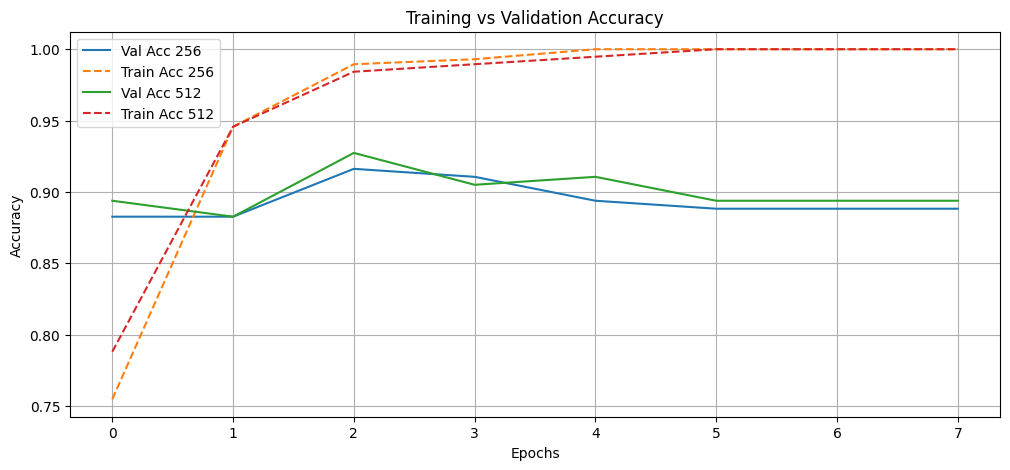

In [98]:
def plot_training(histories, labels):
    plt.figure(figsize=(12, 5))

    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'Val Acc {label}')
        plt.plot(history.history['accuracy'], linestyle='--', label=f'Train Acc {label}')

    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training([history_256, history_512], ['256', '512'])

In [104]:
res_vgg_256 = model_256.evaluate(X_test, y_test)
res_vgg_512 = model_512.evaluate(X_test, y_test)

test_accuracy_vgg_256 = res_vgg_256[-1]
test_accuracy_vgg_512 = res_vgg_512[-1]


print(f"test_accuracy_vgg_256 = {round(test_accuracy_vgg_256,2)*100} %")
print(f"test_accuracy_vgg_512 = {round(test_accuracy_vgg_512,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 123s 24s/step - accuracy: 0.8923 - loss: 1.3146
5/5 ━━━━━━━━━━━━━━━━━━━━ 122s 24s/step - accuracy: 0.9309 - loss: 2.0499
test_accuracy_vgg_256 = 87.0 %
test_accuracy_vgg_512 = 91.0 %
Chance level: 33.3%


## Analysis of Results

The results show that the model with **512 neurons** in the dense layer outperforms the model with 256 neurons in terms of test accuracy.

Here's a detailed analysis:

### **Test Accuracy**:

- Model with 256 neurons : Test accuracy of 89.23%
- **Model with 512 neurons : Test accuracy of 91.0%**

The model with 512 neurons achieves a significantly higher test accuracy.

### **Overfitting**:

The graph indicates that the model with 512 neurons starts to overfit after a few epochs, as the training accuracy continues to increase while the validation accuracy plateaus or slightly decreases.
Despite the overfitting, the test accuracy is better with 512 neurons.

### **Chance Level**:

The chance level is 33.3%, which is expected for a three-class classification problem (daisy, dandelion, rose).

### **Conclusion**:

- **Model Choice**: The model with 512 neurons in the dense layer is clearly the better choice in terms of test accuracy.

- **Handling Overfitting**: Although the model with 512 neurons shows signs of overfitting, it still performs better on the test set.
To mitigate overfitting, consider using techniques such as data augmentation, dropout, or L2 regularization.

## Data Augmentation

In [105]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=(0.5, 1.),
    zoom_range=(0.3, 1.5))

In [111]:
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

train_flow = datagen.flow(X_train, y_train, batch_size=32)
val_flow = datagen.flow(X_val, y_val, batch_size=32)

model_aug = build_model(dense_units=512)

es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

history_aug = model_aug.fit(train_flow,
                            validation_data=val_flow,
                            epochs=50,
                            callbacks=[es])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 649s 36s/step - accuracy: 0.5667 - loss: 25.9059 - val_accuracy: 0.7709 - val_loss: 4.0930
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 685s 39s/step - accuracy: 0.8494 - loss: 1.9525 - val_accuracy: 0.8324 - val_loss: 1.6426
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 685s 39s/step - accuracy: 0.8833 - loss: 0.7138 - val_accuracy: 0.8212 - val_loss: 0.8156
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 630s 35s/step - accuracy: 0.8994 - loss: 0.3406 - val_accuracy: 0.8659 - val_loss: 0.6261
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 632s 36s/step - accuracy: 0.9077 - loss: 0.2586 - val_accuracy: 0.8883 - val_loss: 0.4564
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 639s 36s/step - accuracy: 0.9059 - loss: 0.2465 - val_accuracy: 0.8827 - val_loss: 0.3309
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 700s 39s/step - accuracy: 0.8985 - loss: 0.2314 - val_accuracy: 0.8939 - val_loss: 0.4328
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 692s 39s/step - accuracy: 0.9353 - loss: 0.2112 - val_accuracy: 0

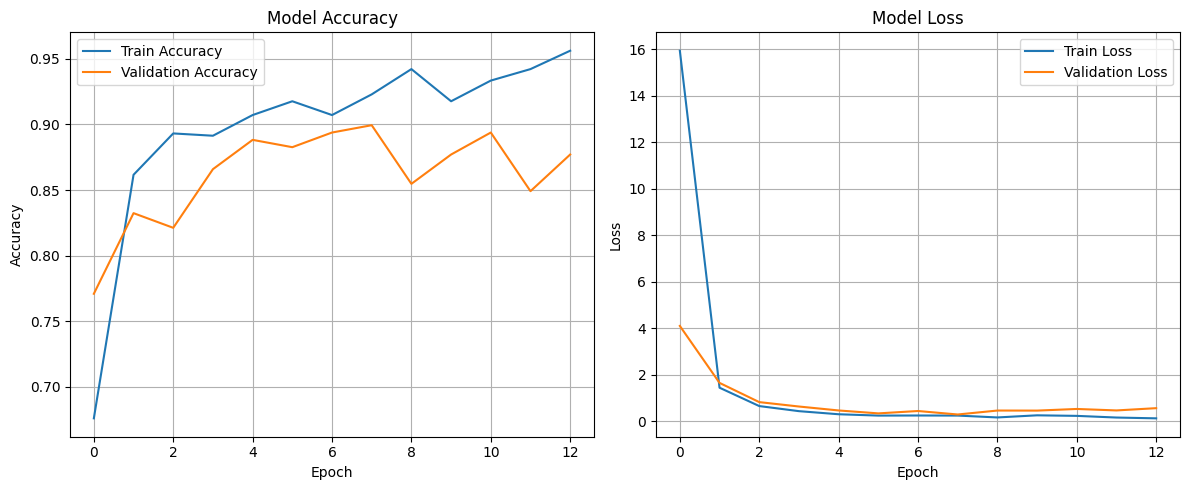

In [119]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_aug.history['loss'], label='Train Loss')
plt.plot(history_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

- **Model Accuracy (left plot)**:

Training accuracy keeps climbing steadily, indicating that the model is learning without any major difficulty.

Validation accuracy flattens out around 88–90%, with some small oscillations — this is typical of a model that’s starting to slightly overfit, but nothing alarming yet.

- **Model Loss (right plot)**:

There’s a sharp drop in training loss early on, then it stabilizes — a sign that the model quickly learns the core patterns.

Validation loss decreases nicely at first, but then plateaus or even ticks upward a bit — another mild sign of overfitting worth keeping an eye on.

🧠 In summary:
My model with data augmantation is learning well, generalizing decently, and showing a very classic behavior for a well-trained model on a medium-sized dataset.

In [113]:
res_aug = model_aug.evaluate(X_test, y_test)
test_accuracy_aug = res_aug[-1]


5/5 ━━━━━━━━━━━━━━━━━━━━ 123s 24s/step - accuracy: 0.9004 - loss: 0.4352


In [118]:
print(f"test_accuracy_aug = {round(test_accuracy_aug,2)*100} %")

print(f"test_accuracy_vgg_512 = {round(test_accuracy_vgg_512,2)*100} %")

print(f"test_accuracy = {round(test_accuracy,2)*100} %")

print(f'Chance level: {1./num_classes*100:.1f}%')

test_accuracy_aug = 89.0 %
test_accuracy_vgg_512 = 91.0 %
test_accuracy = 75.0 %
Chance level: 33.3%


### Conclusion and Analysis of Results

**Test Accuracy:**
   - We evaluated the test accuracy for different models:
     - `test_accuracy_aug`: Test accuracy of the model with data augmentation.
     - `test_accuracy_vgg_512`: Test accuracy of the VGG16 model with 512 neurons in the dense layer.
     - `test_accuracy`: Test accuracy of the base model.
   - The results show that the model with **data augmentation (90%)** and the **VGG16 model with 512 neurons (91%)** achieve higher test accuracies compared to the base model.

**Chance Level:**
   - The chance level is 33.3%, which is expected for a three-class classification problem (daisy, dandelion, rose). This means that if the model were to guess randomly, it would have an accuracy of 33.3%.

### Next Steps for Improvement:

While the current results are promising, there are several areas for improvement:

**Dropout and Regularization:**
   - Adding dropout layers to the model can help prevent overfitting and improve generalization.
   - Implementing L1 and L2 regularization can further enhance the model's performance by penalizing large weights.

### Final Thoughts:

This project demonstrates the potential of using pre-trained models like VGG16 and data augmentation techniques for image classification tasks.

With further improvements and optimizations, this approach can be scaled to handle larger datasets and more complex scenarios.

The results are promising, and with the suggested enhancements, the model's performance can be significantly improved.